In [1]:
import uproot
import numpy as np
import torch
from collections import defaultdict
from util import get_layer, theta_func,create_layer_map,calculate_num_pixels_z_dependence
import matplotlib.pyplot as plot
import time
from collections import defaultdict
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)
from IPython.display import clear_output
from tqdm import tqdm
from torch import nn
from momentum_prediction_util import process_root_file,Predictor, split_data, train,filter_tensors_by_values,new_prepare_nn_input

Using device cuda:0


# Checking data

In [2]:
inputs = torch.load("data/momentum_prediction_pulse/October_23_pim/input/pim_5000events_0.pt",weights_only = True)
outputs = torch.load("data/momentum_prediction_pulse/October_23_pim/output/pim_5000events_0.pt",weights_only = True)
# for i in range(1,101):
#     try:
#         inputs = torch.cat((inputs, torch.load(f"data/momentum_prediction_pulse/October_21/input/pim_2000events_{i}.pt",weights_only = True)))
#         outputs = torch.cat((outputs, torch.load(f"data/momentum_prediction_pulse/October_21/output/pim_2000events_{i}.pt",weights_only = True)))
#     except:
#         print(f"skipped file #{i}")

In [3]:
filtered_inputs, filtered_outputs = filter_tensors_by_values(inputs,outputs)

fraction 1.00 of events survived filters


In [4]:
short_inputs = filtered_inputs[:50]
short_outputs = filtered_outputs[:50]

In [3]:
import normflows as nf
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")
# particle = "pi"
particle = "mu"

# This data will be used for storing plots - today above works if you actually want today
# today = "July_26"

run_num = 7
run_num_str = str(run_num)

#NF Stuff

K = 8 #num flows

latent_size = 1 #dimension of PDF
hidden_units = 256 #nodes in hidden layers
hidden_layers = 26
context_size = 3 #conditional variables for PDF
num_context = 3

K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)
# model_date = "August_03"
# today = "August_03"
# model_path = "models/" + model_date + "/"
# checkdir(model_path)

model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/"

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
model = model.to(device)
model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [4]:
layer_map, super_layer_map = create_layer_map()

In [5]:
def process_root_file(file_path):
    print("began processing")
    with uproot.open(file_path) as file:
        tree_HcalBarrelHits = file["events/HcalBarrelHits"]
        tree_MCParticles = file["events/MCParticles"]
        
        
        momentum_x_MC = tree_MCParticles["MCParticles.momentum.x"].array(library="np")
        momentum_y_MC = tree_MCParticles["MCParticles.momentum.y"].array(library="np")
        momentum_z_MC = tree_MCParticles["MCParticles.momentum.z"].array(library="np")
        
        z_pos = tree_HcalBarrelHits["HcalBarrelHits.position.z"].array(library="np")
        x_pos = tree_HcalBarrelHits["HcalBarrelHits.position.x"].array(library="np")
        energy = tree_HcalBarrelHits["HcalBarrelHits.EDep"].array(library="np")
        momentum_x = tree_HcalBarrelHits["HcalBarrelHits.momentum.x"].array(library="np")
        momentum_y = tree_HcalBarrelHits["HcalBarrelHits.momentum.y"].array(library="np")
        momentum_z = tree_HcalBarrelHits["HcalBarrelHits.momentum.z"].array(library="np")
        hit_time = tree_HcalBarrelHits["HcalBarrelHits.time"].array(library="np")
        mc_hit_idx = file["events/_HcalBarrelHits_MCParticle/_HcalBarrelHits_MCParticle.index"].array(library="np")  # Add PDG code for particle identification
        print("finished loading branches")
        
        processed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        
        for event_idx in tqdm(range(len(z_pos))):
            if(len(z_pos[event_idx]) == 0):
                continue
            primary_momentum = (momentum_x_MC[event_idx][0],
                            momentum_y_MC[event_idx][0],
                            momentum_z_MC[event_idx][0])
            primary_momentum_mag = np.linalg.norm(primary_momentum)
            if(primary_momentum_mag <= 0):
                continue
            if(primary_momentum_mag > 100):
                continue
            energy_per_layer_particle = defaultdict(lambda: defaultdict(float))
            first_hit_per_layer_particle = defaultdict(dict)
            # First pass: collect first hit data and calculate energy per layer per particle
            for hit_idx in range(len(z_pos[event_idx])):
                z = z_pos[event_idx][hit_idx]
                x = x_pos[event_idx][hit_idx]
                e = energy[event_idx][hit_idx]
                momentum = (momentum_x[event_idx][hit_idx],
                            momentum_y[event_idx][hit_idx],
                            momentum_z[event_idx][hit_idx])
                momentum_mag = np.linalg.norm(momentum)
                theta = theta_func(momentum_x[event_idx][hit_idx], momentum_y[event_idx][hit_idx], momentum_z[event_idx][hit_idx])
                layer = get_layer(x)
                particle_id = mc_hit_idx[event_idx][hit_idx]
                
                energy_per_layer_particle[layer][particle_id] += e
                
                if layer not in first_hit_per_layer_particle or particle_id not in first_hit_per_layer_particle[layer]:
                    first_hit_per_layer_particle[layer][particle_id] = {
                        "z_pos": z,
                        "x_pos": x,
                        "momentum": momentum_mag,
                        "primary_momentum": primary_momentum_mag,
                        "theta": theta,
                        "time": hit_time[event_idx][hit_idx],
                        "mc_hit_idx": particle_id
                    }
            
            
            # Second pass: process first hit with total layer energy per particle
            for layer, particle_data in first_hit_per_layer_particle.items():
                for particle_id, hit_data in particle_data.items():
                    layer_particle_energy = energy_per_layer_particle[layer][particle_id]
                    num_pixels_high_z = calculate_num_pixels_z_dependence(layer_particle_energy, hit_data["z_pos"])
                    num_pixels_low_z = calculate_num_pixels_z_dependence(layer_particle_energy, -1 * hit_data["z_pos"])
                    hit_data["num_pixels_high_z"] = int(np.floor(num_pixels_high_z))
                    hit_data["num_pixels_low_z"] = int(np.floor(num_pixels_low_z))
                    hit_data["layer_energy"] = layer_particle_energy  # Store total layer energy for this particle
                    processed_data[event_idx][layer][particle_id.item()] = hit_data
#             if(event_idx > 100):
#                 break
    print("finished processing")
    return processed_data

In [6]:
pref = "/hpc/group/vossenlab/rck32/"
processed_data = process_root_file(pref + "eic/work_eic/root_files/momentum_prediction/October_21/pim_2000events_0_8_to_10GeV_90theta_origin_file_100.edm4hep.root")


began processing
finished loading branches


100%|██████████| 2000/2000 [00:12<00:00, 154.54it/s]

finished processing


In [7]:
def new_prepare_nn_input(processed_data, normalizing_flow, batch_size=1024, device='cuda'):
    nn_input = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    nn_output = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    
    all_context = []
    all_time_pixels = []
    all_metadata = []
    num_pixel_list = ["num_pixels_high_z","num_pixels_low_z"]
    print("Processing data in new_prepare_nn_input...")
    for event_idx, event_data in tqdm(processed_data.items()):
        for layer, layer_data in event_data.items():
            for particle_id, particle_data in layer_data.items():
                primary_momentum = particle_data["primary_momentum"].item()
                base_context = torch.tensor([particle_data['z_pos'], particle_data['theta'], particle_data['momentum']], 
                                            dtype=torch.float32)
                base_time_pixels_low = torch.tensor([particle_data['time'], particle_data['num_pixels_low_z']], 
                                                dtype=torch.float32)
                base_time_pixels_high = torch.tensor([particle_data['time'], particle_data['num_pixels_high_z']], 
                                                dtype=torch.float32)
                
                for SiPM_idx in range(2):
                    z_pos = particle_data['z_pos']
                    context = base_context.clone()
                    context[0] = z_pos
                    num_pixel_tag = num_pixel_list[SiPM_idx]
                    all_context.append(context.repeat(particle_data[num_pixel_tag], 1))
                    if(SiPM_idx == 0):
                        all_time_pixels.append(base_time_pixels_high.repeat(particle_data[num_pixel_tag], 1))
                    else:
                        all_time_pixels.append(base_time_pixels_low.repeat(particle_data[num_pixel_tag], 1))
                    all_metadata.extend([(event_idx, layer, SiPM_idx, particle_id, primary_momentum)] * particle_data[num_pixel_tag])

    all_context = torch.cat(all_context)
    all_time_pixels = torch.cat(all_time_pixels)
    
    print("Sampling data...")
    sampled_data = []
    begin = time.time()
    print(len(all_context))
    for i in tqdm(range(0, len(all_context), batch_size)):
        batch_end = min(i + batch_size, len(all_context))
#         print(f"batch_end - i: {batch_end - 1}")
        batch_context = all_context[i:batch_end].to(device)
        batch_time_pixels = all_time_pixels[i:batch_end]
        
        with torch.no_grad():
            samples = abs(normalizing_flow.sample(num_samples=len(batch_context), context=batch_context)[0]).squeeze(1)
        
        sampled_data.extend(samples.cpu() + batch_time_pixels[:, 0])
    end = time.time()
    print(f"sampling took {end - begin} seconds")
    print("Reorganizing data...")
    begin = time.time()
    for (event, layer, SiPM, particle, momentum), sample in zip(all_metadata, sampled_data):
        nn_input[event][layer][SiPM].append(sample)
        nn_output[event][layer][SiPM].append(torch.tensor([momentum]))
    end = time.time()
    print(f"reorganizing took {end - begin} seconds")
    return nn_input, nn_output


In [8]:
nn_input, nn_output = new_prepare_nn_input(processed_data, model_compile,batch_size = 50000)

Processing data in new_prepare_nn_input...


100%|██████████| 2000/2000 [00:44<00:00, 45.36it/s]


Sampling data...
27173607


100%|██████████| 544/544 [06:23<00:00,  1.42it/s]


sampling took 383.1026062965393 seconds
Reorganizing data...
reorganizing took 122.61094164848328 seconds


In [9]:
import numpy as np
from scipy import signal

class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1e-9,       # 1 ns rise time
                 tau_fall=10e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = (1 - np.exp(-self.time/self.tau_rise)) * np.exp(-self.time/self.tau_fall)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return -1
    def cdf_timing(self,waveform):
        delayed_waveform = waveform + self.cfd_delay
        inverse_waveform = waveform * self.cfd_fraction
        combined_waveform = inverse_waveform - delayed_waveform
        
    def cfd_timing(self, waveform):
        """Implement Constant Fraction Discrimination timing"""
        # Create delayed and attenuated versions
        delay_samples = int(self.cfd_delay * self.sampling_rate)
        delayed = np.roll(waveform, delay_samples)
        attenuated = waveform * self.cfd_fraction
        
        # CFD waveform
        cfd_signal = attenuated - delayed
        
        # Find zero crossing
        zero_crossings = np.where(np.diff(np.signbit(cfd_signal)))[0]
        
        if len(zero_crossings) > 0:
            # Linear interpolation for more precise timing
            idx = zero_crossings[0]
            t1, t2 = self.time[idx], self.time[idx+1]
            v1, v2 = cfd_signal[idx], cfd_signal[idx+1]
            
            # Time at zero crossing
            zero_time = t1 - v1 * (t2 - t1) / (v2 - v1)
            return zero_time
        else:
            return None

In [15]:
(1655 + 640) / 10

229.5

In [10]:
# CFD
processor = SiPMSignalProcessor(cfd_fraction = 0.3)    
photon_times = torch.tensor(sorted(nn_input[0][1][0])) * 10 **(-9) #times in s
#get relative times
min_time = photon_times[0] #lowest value of photon times
photon_times = photon_times - min_time #start at 0
time_list,waveform = processor.generate_waveform(photon_times) #returns time in s
charge = processor.integrate_charge(waveform)
timing = processor.cfd_timing(waveform) + min_time.item() #Convert to absolute time
adjusted_times = time_list + np.ones(len(time_list)) * min_time.item() #convert to absolute time

In [11]:
# Constant Threshold
processor = SiPMSignalProcessor(cfd_fraction = 0.3)    
photon_times = torch.tensor(sorted(nn_input[0][1][0])) * 10 **(-9) #times in s
#get relative times
time_list,waveform = processor.generate_waveform(photon_times) #returns time in s
charge = processor.integrate_charge(waveform)
timing = processor.constant_threshold_timing(waveform,2)

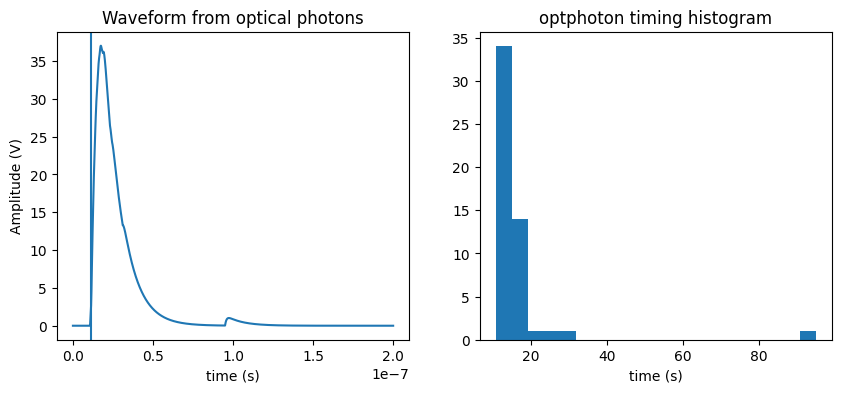

In [12]:
fig, axs = plot.subplots(1,2,figsize = (10,4))
axs[0].plot(time_list,waveform);
axs[1].hist(np.array(nn_input[0][1][0]),bins = 20);
axs[1].set_title("optphoton timing histogram")
axs[0].set_xlabel("time (s)")
axs[1].set_xlabel("time (s)")
axs[0].set_ylabel("Amplitude (V)")
axs[0].set_title("Waveform from optical photons")
axs[0].axvline(timing)
plot.show()
# fig.savefig("waveform.pdf")

In [13]:
processor = SiPMSignalProcessor(cfd_fraction = 0.3)    
timing_arr = np.ones(len(nn_input)) * 999
#loop over all events
for i in range(len(nn_input)):
    #only look at first layer, one SiPM
    times = torch.tensor(nn_input[i][0][0]) * 10 **(-9)
    time_list,waveform = processor.generate_waveform(times) #returns time in s
    charge = processor.integrate_charge(waveform)
    timing = processor.constant_threshold_timing(waveform,10)
    if(timing < 0):
        print(f"skipped event #{i} because threshold not met")
    else:
        timing_arr[i] = timing

skipped event #505 because threshold not met
skipped event #593 because threshold not met
skipped event #597 because threshold not met
skipped event #814 because threshold not met
skipped event #1571 because threshold not met
skipped event #1818 because threshold not met
skipped event #1933 because threshold not met


In [ ]:
prediction_input, prediction_output= prepare_prediction_input_pulse(nn_input,nn_output)

Cutting out bad data that has output = 9999 and putting good data in oct_6

In [51]:
# for file_num in range(51):
#     test_in = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{file_num}.pt",weights_only = True)
#     test_out = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{file_num}.pt",weights_only = True)
#     for i in range(len(test_out)):
#         if(test_out[i] == 9999):
#             print(f"file #{file_num}, event #{i}")

In [48]:
# file_num = 50
# test_in = torch.load(f"data/momentum_prediction_pulse/Oct_3/input_5k_n_slurm_{file_num}.pt",weights_only = True)
# test_out = torch.load(f"data/momentum_prediction_pulse/Oct_3/output_5k_n_slurm_{file_num}.pt",weights_only = True)

In [49]:
# cut_inputs = torch.cat((test_in[:3085],test_in[3086:]))
# cut_outputs = torch.cat((test_out[:3085],test_out[3086:]))

In [50]:
# torch.save(cut_inputs,f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{file_num}.pt")
# torch.save(cut_outputs,f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{file_num}.pt")

In [5]:
inputs = torch.load("data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_0.pt",weights_only = True)
outputs = torch.load("data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_0.pt",weights_only = True)
for i in range(1,51):
    new_input = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/input_5k_n_slurm_{i}.pt",weights_only = True)
    inputs = torch.cat((inputs,new_input))
    new_output = torch.load(f"data/momentum_prediction_pulse/Oct_6_cut_bad_events/output_5k_n_slurm_{i}.pt",weights_only = True)
    outputs = torch.cat((outputs,new_output))

In [6]:
scaled_inputs = inputs
for i in range(len(inputs)):
    for j in range(len(inputs[i])):
        if(inputs[i][j][1] == 9999):
            scaled_inputs[i][j][1] = 0
        scaled_inputs[i][j][0] *= 1e6 
        scaled_inputs[i][j][1] *= 1e8

In [7]:
train_data, val_data, test_data, split_info = split_data(
    scaled_inputs, outputs
)

In [8]:
from torch import nn
from reco import Predictor
num_layers = 28
num_input_features_per_layer = 2
model = Predictor(input_size=num_layers * num_input_features_per_layer, num_classes=1, hidden_dim = num_layers * num_input_features_per_layer * 2, num_layers = 16)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [9]:
loss_hist,val_hist = train(model,train_data['inputs'],train_data['outputs'],val_data['inputs'],val_data['outputs'],optimizer,device,num_epochs = 200, batch_size = 256)

Epoch 151/200


100%|██████████| 694/694 [00:03<00:00, 207.31it/s]


Epoch 151 - Train Loss: 1.1813, Val Loss: 1.2187
Early stopping triggered after epoch 151
loaded best model
Finished Training


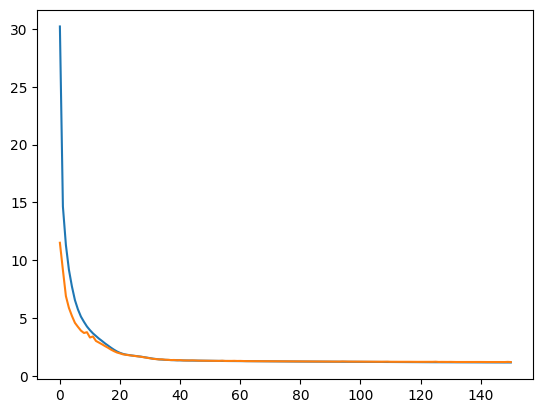

In [10]:
plot.plot(loss_hist);
plot.plot(val_hist);

In [11]:
def calculate_metrics(y_true, y_pred):

    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mse = np.mean((y_true - y_pred) ** 2)  # Mean Squared Error
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # R-squared calculation
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r_squared': r_squared
    }

In [12]:
dataset = test_data
real_out = dataset['outputs']
model_out = np.zeros(len(real_out))
model_out = np.zeros(len(dataset['outputs']))
for i in range(len(model_out)):
    model_out[i] = model(dataset['inputs'][i].flatten().to(device)).detach().cpu()
    

In [14]:
m_n = 0.939565 #GeV
learned_e = np.sqrt(model_out ** 2 + m_n ** 2)
true_e = np.sqrt(real_out ** 2 + m_n ** 2)

/tmp/ipykernel_1720454/3443016634.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_e = np.sqrt(real_out ** 2 + m_n ** 2)


In [ ]:
e_lb = 0.8
e_ub = 10
num_bins = 20
bin_edges = np.linspace(0.5,10,num_bins + 1)

binned_model_out_list = [[] for _ in range(num_bins)]
binned_real_out_list = [[] for _ in range(num_bins)]
for i in range(len(true_e)):
    for j in range(1,len(bin_edges)):
        if(true_e[i] < bin_edges[j]):
            binned_model_out_list[j - 1].append(learned_e[i])
            binned_real_out_list[j - 1].append(true_e[i])
            break
binned_real_out = binned_real_out_list
binned_model_out = binned_model_out_list

In [ ]:
bin_centers = np.array(bin_edges[1:]) - (bin_edges[1] - bin_edges[0]) / 2

In [ ]:
len(bin_centers)

In [62]:
RMSE_arr = np.zeros(len(bin_centers))
rel_RMSE_arr = np.zeros(len(bin_centers))
for i in range(len(bin_centers)):
    mse = np.mean((np.array(binned_real_out[i]) - np.array(binned_model_out[i])) ** 2)  # Mean Squared Error
    RMSE_arr[i] = np.sqrt(mse)  # Root Mean Squared Error 
    rel_RMSE_arr[i] = np.sqrt(mse) / bin_centers[i]  # Root Mean Squared Error

In [67]:
def fit_func(e,a,c):
    return a / np.sqrt(e)  + c

from scipy import optimize
popt,pcov = optimize.curve_fit(fit_func,bin_centers,rel_RMSE_arr)

fitted_rel_RMSE = np.zeros(len(bin_centers))
for i in range(len(bin_centers)):
    fitted_rel_RMSE[i] = fit_func(bin_centers[i],*popt)

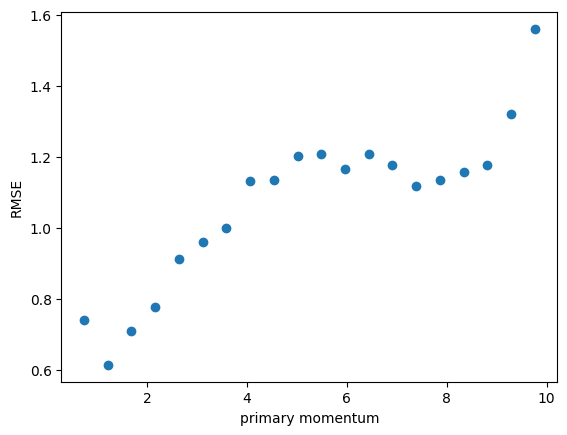

In [68]:
plot.scatter(bin_centers,RMSE_arr)
# plot.plot(bin_centers[1:],fitted_rel_RMSE,color = "red")
plot.xlabel("primary momentum")
plot.ylabel("RMSE")
plot.show();
# plot.savefig("fit_rel_RMSE.jpeg")

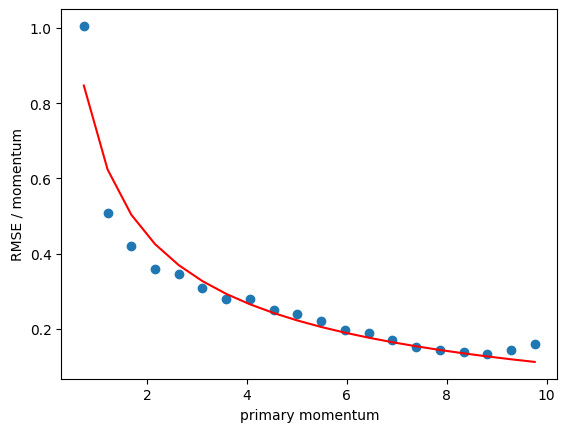

In [69]:
plot.scatter(bin_centers,rel_RMSE_arr)
plot.plot(bin_centers,fitted_rel_RMSE,color = "red")
plot.xlabel("primary momentum")
plot.ylabel("RMSE / momentum")
plot.show();
# plot.savefig("fit_rel_RMSE.jpeg")

In [70]:
# print(f"a,b,c: %.2f,%.2f,%.2f"%(popt[0],popt[1],popt[2]))
print(f"a,c: %.2f,%.2f"%(popt[0],popt[1]))

a,c: 0.87,-0.17


In [71]:
# Regression example
true_values = dataset['outputs']
pred_values = model_out
reg_metrics = calculate_metrics(true_values, pred_values)
print("\nRegression Metrics:")
print(f"Mean Squared Error: {reg_metrics['mse']:.4f}")
print(f"Root Mean Squared Error: {reg_metrics['rmse']:.4f}")
print(f"Mean Absolute Error: {reg_metrics['mae']:.4f}")
print(f"R-squared: {reg_metrics['r_squared']:.4f}")


Regression Metrics:
Mean Squared Error: 1.2190
Root Mean Squared Error: 1.1041
Mean Absolute Error: 0.8150
R-squared: 0.8263


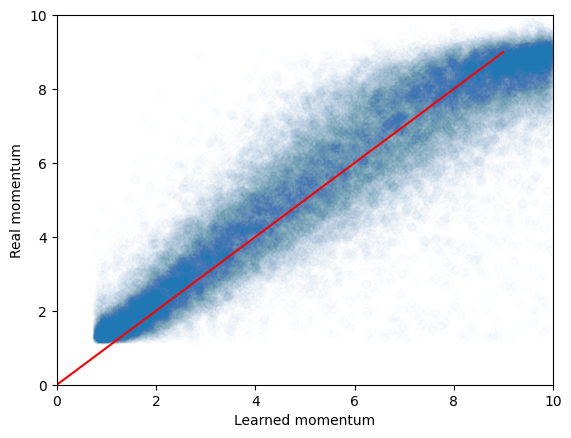

In [73]:
plot.scatter(dataset['outputs'],model_out, alpha = 0.01)
plot.plot(range(10),color = "red");
plot.xlabel("Learned momentum")
plot.ylabel("Real momentum")
plot.ylim(0,10)
plot.xlim(0,10)
plot.plot();